# Fraud Detection System - V1: Baseline Models

**Date:** 2026-01-30  
**Author:** *Luis Renteria Lezano*  
[LinkedIn](https://www.linkedin.com/in/renteria-luis) | [GitHub](https://github.com/renteria-luis)

## Executive Summary

**The Problem:** Detecting fraud in a $598:1$ imbalanced dataset (Credit Card Fraud).  
**The Solution:** Optimized Tuned XGBoost Pipeline.  

**Key Results**  
- **Recall:** **87%** (Captured nearly 9/10 frauds).  
- **PR-AUC:** **0.88** (High class separation).  
- **Business Decision:** Operational threshold set at **0.2072** to maximize revenue protection over false alarms.  
  

**Technical Edge**  
- **End-to-End Pipeline:** Automated Feature Engineering (Log-Trans, Cyclical Encoding) + Model.  
- **Zero Leakage:** Strict use of `ColumnTransformer` and Stratified 5-Fold CV.  
- **Bottom Line:** This V1 establishes a high-performance baseline. Moving to **Deep Learning (V2)** to address the current 12% overfitting gap.

**Info**
- **Source:** This analysis uses the Credit Card Fraud Detection dataset published on [Kaggle by MLG ULB](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).  
- **Data:** [../data/raw/creditcard.csv](../data/raw/creditcard.csv). 
- **Feature Engineering:** Applied from [../src/features.py](../src/features.py), fitted on `X_train` and transformed on both train and test.
- **Target variable:** `Class`:
    - 0 = legitimate transaction  
    - 1 = fraudulent transaction  

## 1. Reproducibility & Environment Setup
- Pin versions in [../requirements.txt](../requirements.txt).
- Keep raw data immutable [../data/raw](../data/raw).

In [80]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import joblib
import json
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import precision_recall_curve

from sklearn.pipeline import Pipeline
sys.path.append('..')
from src.features import FeatureEngineering
from src.models import training_pipeline
from src.evaluation import evaluate_model
from src.utils import sanitize_dict

# 1. Global Reproducibility
SEED = 42
np.random.seed(SEED)

# 2. Path Management
BASE_DIR = Path("..")
DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"

# 3. Plotting Style
sns.set_theme(style='whitegrid', context='notebook', palette='viridis')
plt.rcParams["figure.figsize"] = (10, 6)

# 4. Global Settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Load & Split Data

In [2]:
raw_file = DATA_RAW / "creditcard.csv"
df = pd.read_csv('../data/raw/creditcard.csv')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0


In [3]:
X = df.drop('Class', axis=1)
y = df[['Class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

X_train.to_parquet(DATA_PROCESSED / 'X_train.parquet', index=False)
X_test.to_parquet(DATA_PROCESSED / 'X_test.parquet', index=False)
y_train.to_parquet(DATA_PROCESSED / 'y_train.parquet', index=False)
y_test.to_parquet(DATA_PROCESSED / 'y_test.parquet', index=False)

print(f'''> Training set has: {X_train.shape[0]} samples
> Test set has: {X_test.shape[0]} samples
> # of features: {len(X_test.columns)}''')

> Training set has: 227845 samples
> Test set has: 56962 samples
> # of features: 30


## 3. Available Features

In [4]:
fe = FeatureEngineering()
X_fe = fe.fit_transform(X_train)

bool_cols = ['is_micro_transaction', 'is_large_transaction', 'is_night']
num_cols = list(set(X_fe.select_dtypes(['number', 'float64', 'int64']).columns) - set(bool_cols))
cat_cols = X_fe.select_dtypes(['string', 'category', 'object']).columns

print(f"Numerical Features ({len(num_cols)}): {', '.join(num_cols)}\n")
print(f"Categorical Features ({len(cat_cols)}): {', '.join(cat_cols.tolist())}\n")
print(f"Boolean Features ({len(bool_cols)}): {', '.join(bool_cols)}")

Numerical Features (32): V7, V21, V2, amount_log, V22, V27, V11, V6, V26, V23, V17, V24, V9, V10, V18, hour_cos, V14, V20, V25, hour_sin, V12, Amount, V15, V1, V5, V13, V19, V4, V8, V28, V3, V16

Categorical Features (0): 

Boolean Features (3): is_micro_transaction, is_large_transaction, is_night


## 4. Preprocessing

### 4.1 Preprocessor Pipeline
- **Feature Engineering**: implemented in [src/features.py](../src/features.py) (`FeatureEngineering` class). Creates new features:
  - Numeric / continuous: `amount_log`, `is_micro_transaction`, `is_large_transaction`
  - Time / cyclical: `hour`, `is_night`, `hour_sin`, `hour_cos`, (`Time` dropped)
- **Data imputation / scaling**: implemented in [src/pipelines.py](../src/pipelines.py) handles everything inside the `training_pipeline` via `ColumnTransformer` and `Pipeline`:
  - Numeric features: median imputation (and scaling for logistic regression)
  - Boolean features: most frequent imputation
- **Pipeline application**: preprocessing is executed **inside the pipeline**, so no manual transformation is needed in the notebook.
- **Models available in this project**: Logistic Regression, Random Forest & Extreme Gradient Boosting:

```python
available_models = ['logreg', 'rf', 'xgb']
pipe = training_pipeline('rf', params={'n_estimators': 100})
pipe.fit(X_train, y_train.values.ravel())  # as we need a 1D array
y_pred = pipe.predict(X_test)
```

## 5. Modeling & Evaluation
Given the imbalance and the cost of fraud, we will not use Accuracy.

**Fraud Detection Metrics**

| Metric | What It Measures | If It Increases | If It Decreases | Priority |
|--------|------------------|-----------------|-----------------|----------|
| **Recall** | How many real frauds we catch | Catch more fraud → **lose less money** | Miss more fraud → **lose money directly** | **#1 CRITICAL** |
| **Precision** | How many alerts are actual fraud | Fewer false alarms → lower ops costs, happier customers | More false alarms → high costs, customer friction | **#2 IMPORTANT** |
| **PR-AUC** | Model's overall fraud separation ability | Better fraud detection globally | Worse fraud detection globally | **#3 KEY** |
| **F1-Score** | Balance of precision and recall | Redundant (Recall + Precision) | - | **NOT USED** |
| **ROC-AUC** | General class separability | PR-AUC works better here | - | **NOT USED** |
| **Accuracy** | Overall correctness | **Misleading** - model predicting all as "not fraud" gets 99%+ | **NOT USED** | **NOT USED** |

**Priority Hierarchy**  
1. **Recall** — Catch fraud (revenue protection)
2. **Precision** — Control costs (ops efficiency)  
3. **PR-AUC** — Model comparison

**Optimal Trade-offs**
- **Maximize Recall subject to a minimum Precision floor** — Better to investigate 10 legit cases than miss 1 fraud
- **Set minimum Recall threshold** (e.g., 85%) then optimize Precision within that constraint
- **Use lower decision threshold** to catch more fraud, even if it means more false alarms

### 5.1 Baseline Model

#### Training

In [5]:
models = ['logreg', 'rf', 'xgb']
pipes = {}

print('Baseline training (default hyperparameters)...')
for model_name in models:
    print(f'Training {model_name}...')  
    pipe = training_pipeline(model_name=model_name)
    pipe.fit(X_train, y_train.values.ravel())
    pipes[model_name + '_baseline'] = pipe
print('Done.')

Baseline training (default hyperparameters)...
Training logreg...
Training rf...
Training xgb...
Done.


#### Evaluation

ALERT: Signs of overfitting detected in Random Forest: Diff: 12.5857%.
ALERT: Signs of overfitting detected in XGBoost: Diff: 12.1042%.


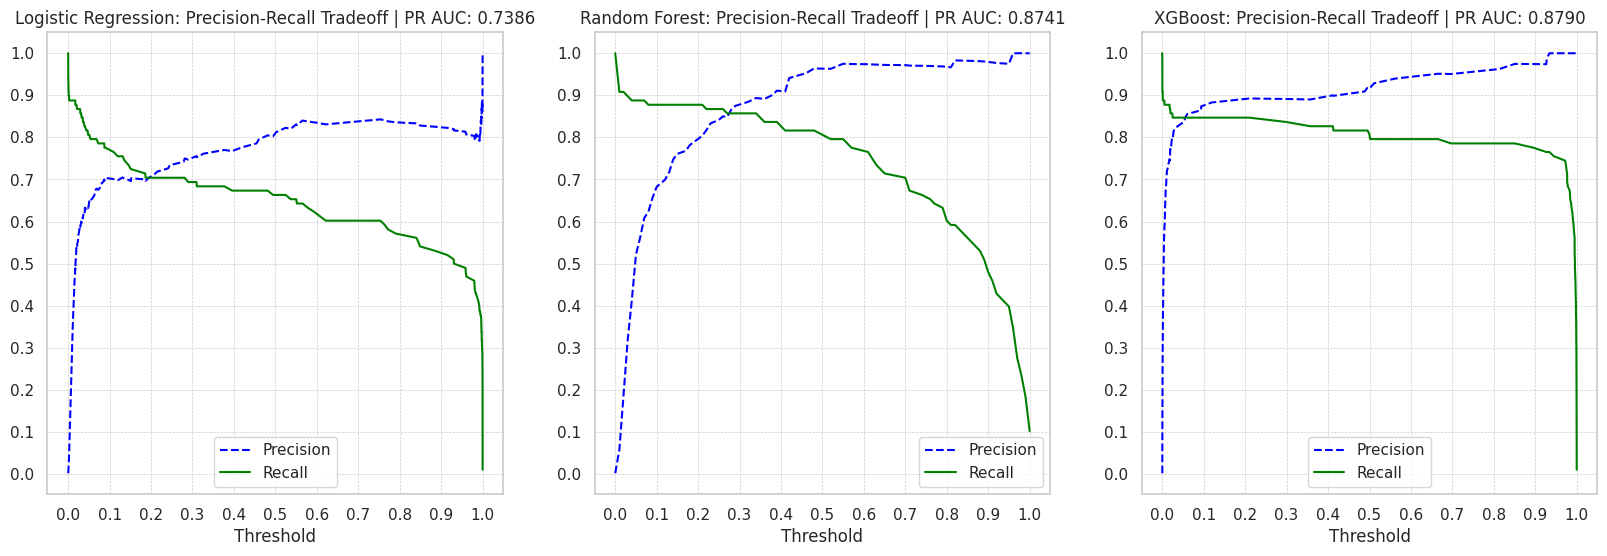

<Figure size 1000x600 with 0 Axes>

In [6]:
results = {}

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
results['logreg_baseline'] = evaluate_model(pipes['logreg_baseline'], X_train, y_train, X_test, y_test, "Logistic Regression", ax=ax[0])
results['rf_baseline'] = evaluate_model(pipes['rf_baseline'], X_train, y_train, X_test, y_test, "Random Forest", ax=ax[1])
results['xgb_baseline'] = evaluate_model(pipes['xgb_baseline'], X_train, y_train, X_test, y_test, "XGBoost", ax=ax[2])
plt.tight_layout()
plt.show()

**Insights:**  
- Baseline shows high variance (overfitting). Next step focuses on regularization.
- Tree-based models, by default in scikit-learn, are set to be "greedy"; they grow until each leaf is pure. This is perfect memorization of the Train Set (PR-AUC ~1.0) and a drop in Test.
- XGBoost Default: Even though it has regularization, without tuning it often learns noise aggressively.

### 5.2 Hyperparameter Tuning

#### Training

In [16]:
# Calculate exact ratio FIRST
pos_weight = int(((y_train == 0).sum() / (y_train == 1).sum()).item())
print(f"Exact imbalance ratio: {pos_weight}")  # ~598

models = {
    'logreg': {
        'name': 'Logistic Regression',
        'params': {
            'model__C': np.logspace(-2, 1, 15),
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs'],
            'model__class_weight': ['balanced'],
        },
        'n_iter': 15
    },
    
    'xgb': {
        'name': 'XGBoost',
        'params': {
            'model__n_estimators': [200, 300, 500],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [5, 7, 10],
            'model__min_child_weight': [3, 5],
            'model__subsample': [0.7, 0.8],
            'model__colsample_bytree': [0.8, 0.9],
            'model__gamma': [0, 0.1],
            'model__scale_pos_weight': [  #  explore near the real ratio
                int(pos_weight * 0.5),   # ~299
                int(pos_weight * 0.75),  # ~448
                pos_weight,              # ~598 (exact ratio)
                int(pos_weight * 1.25)   # ~747
            ],
            'model__reg_lambda': [1, 5, 10],
        },
        'n_iter': 80
    }
}


Exact imbalance ratio: 577


In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

print('Tuned training...')

for model_name, model_config in models.items():
    print(f'Training {model_config["name"]}...')  

    pipe = training_pipeline(model_name=model_name)

    
    cv = RandomizedSearchCV(
        pipe,
        model_config['params'],
        n_iter=model_config['n_iter'],
        cv=skf,                       # stratified kfold important for imbalanced class
        scoring='average_precision',  # PR-AUC
        random_state=SEED,
        n_jobs=-1,
        verbose=1
    )
    
    cv.fit(X_train, y_train.values.ravel())
    
    pipes[model_name + '_tuned'] = cv
    
print('Done.')   

Tuned training...
Training Logistic Regression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Training XGBoost...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Done.


#### Evaluation

ALERT: Signs of overfitting detected in XGBoost: Diff: 12.0182%.


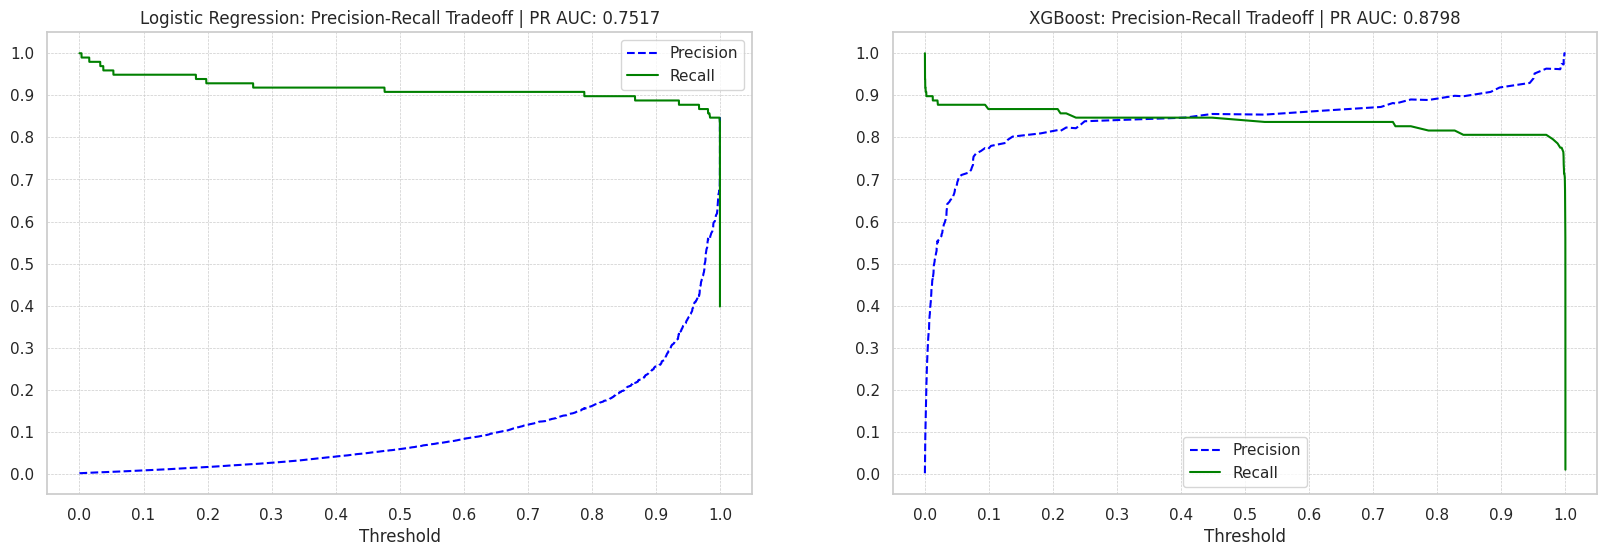

<Figure size 1000x600 with 0 Axes>

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
results['logreg_tuned'] = evaluate_model(pipes['logreg_tuned'], X_train, y_train, X_test, y_test, "Logistic Regression", ax=ax[0])
results['xgb_tuned'] = evaluate_model(pipes['xgb_tuned'], X_train, y_train, X_test, y_test, "XGBoost", ax=ax[1])
plt.tight_layout()
plt.show()

### 5.3 Threshold Tuning

In [52]:
### Get probabilities
y_prob = pipes['xgb_tuned'].predict_proba(X_test)[:, 1]

# Calculate precision/recall at all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Find threshold where recall >= 80% with max precision
target_recall = 0.86
mask = recalls[:-1] >= target_recall
optimal_idx = np.argmax(precisions[:-1][mask])
optimal_threshold = thresholds[mask][optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"  Recall:    {recalls[:-1][mask][optimal_idx]:.2%}")
print(f"  Precision: {precisions[:-1][mask][optimal_idx]:.2%}")

# Predict with optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Compare with default 0.5
y_pred_default = (y_prob >= 0.5).astype(int)

from sklearn.metrics import classification_report
print("\n=== Default Threshold (0.5) ===")
print(classification_report(y_test, y_pred_default, target_names=['Legitimate', 'Fraud']))

print(f"\n=== Optimal Threshold ({optimal_threshold:.4f}) ===")
print(classification_report(y_test, y_pred_optimal, target_names=['Legitimate', 'Fraud']))

Optimal threshold: 0.2072
  Recall:    86.73%
  Precision: 81.73%

=== Default Threshold (0.5) ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.85      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962


=== Optimal Threshold (0.2072) ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.82      0.87      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## 6. Conclusions (V1)

**Operational Strategy: Recall vs. Precision Trade-off**

The mathematically "optimal" threshold (F1 balance) was identified at 0.97 (Precision: 0.96, Recall: 0.81), but it was discarded for being too conservative operationally.

* Final selection: a threshold of 0.2072 was implemented.
* Rationale: this prioritizes recall (0.87), capturing 6% more fraud cases compared to the baseline. In financial fraud detection, the cost of missing a fraud case outweighs the operational cost of an extra verification alert.

**Resource Optimization & Model Selection**

* Random Forest: hyperparameter tuning was skipped. Baseline results showed poor ROI in terms of computation time versus expected performance gain.
* Ensemble methods: a Voting Classifier was evaluated but rejected. The small PR-AUC improvement (+0.08%) during XGBoost tuning suggests conventional ML models have reached a performance ceiling with this feature set.

**Evaluation Framework & Metric Integrity**

* Metric selection: performance was measured using recall, precision, and PR-AUC. Unlike accuracy or ROC-AUC, these metrics give a more accurate view under extreme class imbalance (598:1).
* Overfitting tolerance: a ~12% PR-AUC gap was observed. While notable, it is acceptable for a V1 model in this domain, as PR-AUC is sensitive to the minority class. This gap supports the use of stronger regularization in future iterations.

## 7. Next Steps & Future Work (V2)

Version 1 established a solid baseline with a PR-AUC of 0.8798. The observed overfitting gap and limited gains from classical gradient boosting suggest we need new approaches for Version 2.0.

**Model Architecture**

* Explore deep learning for tabular data, such as feed-forward neural networks, to capture non-linear interactions that tree-based models may miss.
* Consider unsupervised approaches like autoencoders to generate anomaly scores that enhance supervised fraud detection.

**Explainability & Analysis**

* Use SHAP or similar tools to explain high-risk predictions and identify which features contribute to false negatives.
* Leverage insights from explainability for targeted feature engineering and model improvement.

**Feature Engineering & Deployment**

* Enhance features with temporal aggregations and interaction terms for richer context.
* Prepare for deployment with a robust pipeline, containerization, and monitoring for data drift to maintain model performance over time.

## 8. Exporting Model

In [79]:
final_model = pipes['xgb_tuned'].best_estimator_
joblib.dump(final_model, MODELS_DIR / 'fraud_detection_v1_xgb.pkl')

# Metadata
metadata = {
    'version': '1.0.0',
    'model_type': 'XGBoost (Tuned)',
    'training_date': datetime.now().strftime('%Y-%m-%d'),
    'best_params': pipes['xgb_tuned'].best_params_,
    'performance': {
        'pr_auc': 0.8798,
        'baseline_comparison': {
            'baseline_pr_auc': 0.8790,
            'tuned_pr_auc': 0.8798,
            'improvement': '+0.08%'
        },
        'production_config': {
            'threshold': optimal_threshold,
            'precision': 0.82,
            'recall': 0.87,
            'f1': 0.84
        }
    }
}
clean_metadata = sanitize_dict(metadata)
with open(MODELS_DIR / 'metadata_v1.json', 'w') as f:
    json.dump(clean_metadata, f, indent=2)

print('V1 Model Exported')
print(f'   Threshold: {optimal_threshold:.4f}')
print(f'   Precision: 82%')
print(f'   Recall: 87%')

V1 Model Exported
   Threshold: 0.2072
   Precision: 82%
   Recall: 87%
